<a href="https://colab.research.google.com/github/techzro/ML-potato-disease/blob/main/potato_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/PlantVillage",
    shuffle = True,
    image_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

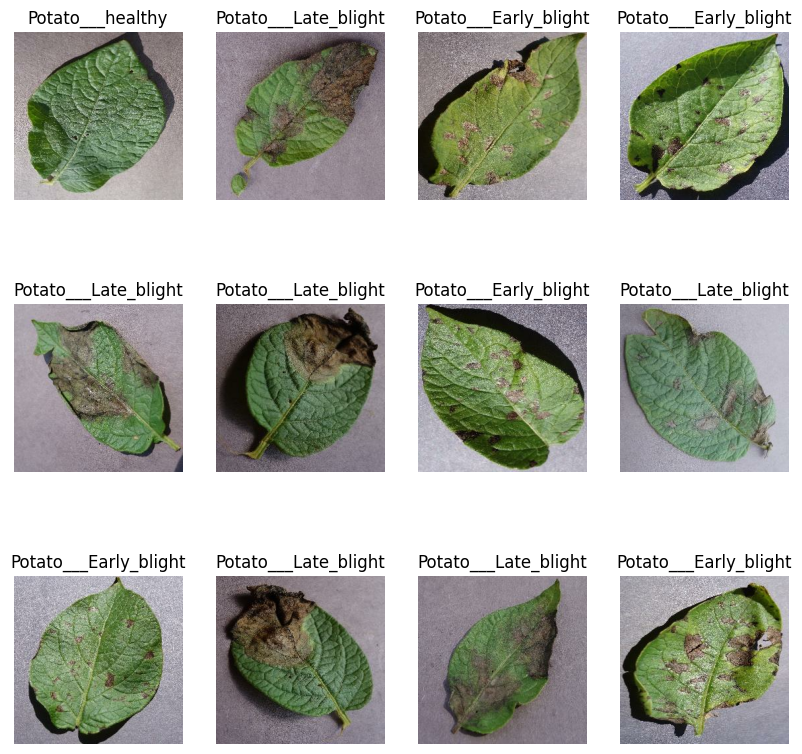

In [ ]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    # print(image_batch[0].shape)
    # print(image_batch.shape)
    # print(label_batch.numpy())

In [ ]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)



In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best weights
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/PlantVillage/best_model.keras',  # Filepath to save the model
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min'  # We want the minimum validation loss
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by half
    patience=3,         # Wait 3 epochs before reducing
    min_lr=1e-6         # Minimum learning rate
)

In [ ]:
 history = model.fit(
     train_ds,
     epochs = EPOCHS,
     batch_size = BATCH_SIZE,
     verbose = 1,
     validation_data = val_ds,
     callbacks=[early_stopping, model_checkpoint, reduce_lr]
 )

Epoch 1/30
54/54 [==============================] - 45s 582ms/step - loss: 0.8819 - accuracy: 0.4971 - val_loss: 0.8454 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 2/30
54/54 [==============================] - 28s 517ms/step - loss: 0.6117 - accuracy: 0.7240 - val_loss: 0.5036 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 3/30
54/54 [==============================] - 28s 525ms/step - loss: 0.4528 - accuracy: 0.8212 - val_loss: 0.3752 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 4/30
54/54 [==============================] - 28s 520ms/step - loss: 0.3376 - accuracy: 0.8663 - val_loss: 0.6181 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/30
54/54 [==============================] - 28s 520ms/step - loss: 0.3155 - accuracy: 0.8640 - val_loss: 0.5508 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 6/30
54/54 [==============================] - 28s 518ms/step - loss: 0.2994 - accuracy: 0.8837 - val_loss: 0.3528 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 7/30
54/54 [==============================] - 28s 521ms/st

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/content/drive/My Drive/my_model_30ep.keras')


OSError: No file or directory found at /content/drive/My Drive/my_model_30ep.keras

In [ ]:
scores = loaded_model.evaluate(test_ds)

NameError: name 'loaded_model' is not defined

In [ ]:
scores

NameError: name 'scores' is not defined

In [ ]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:", first_label)
  print("first image's actual label:", class_names[first_label])

  batch_prediction = loaded_model.predict(images_batch)
  print("predicted label: ",
  class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)  # Create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])))
  return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


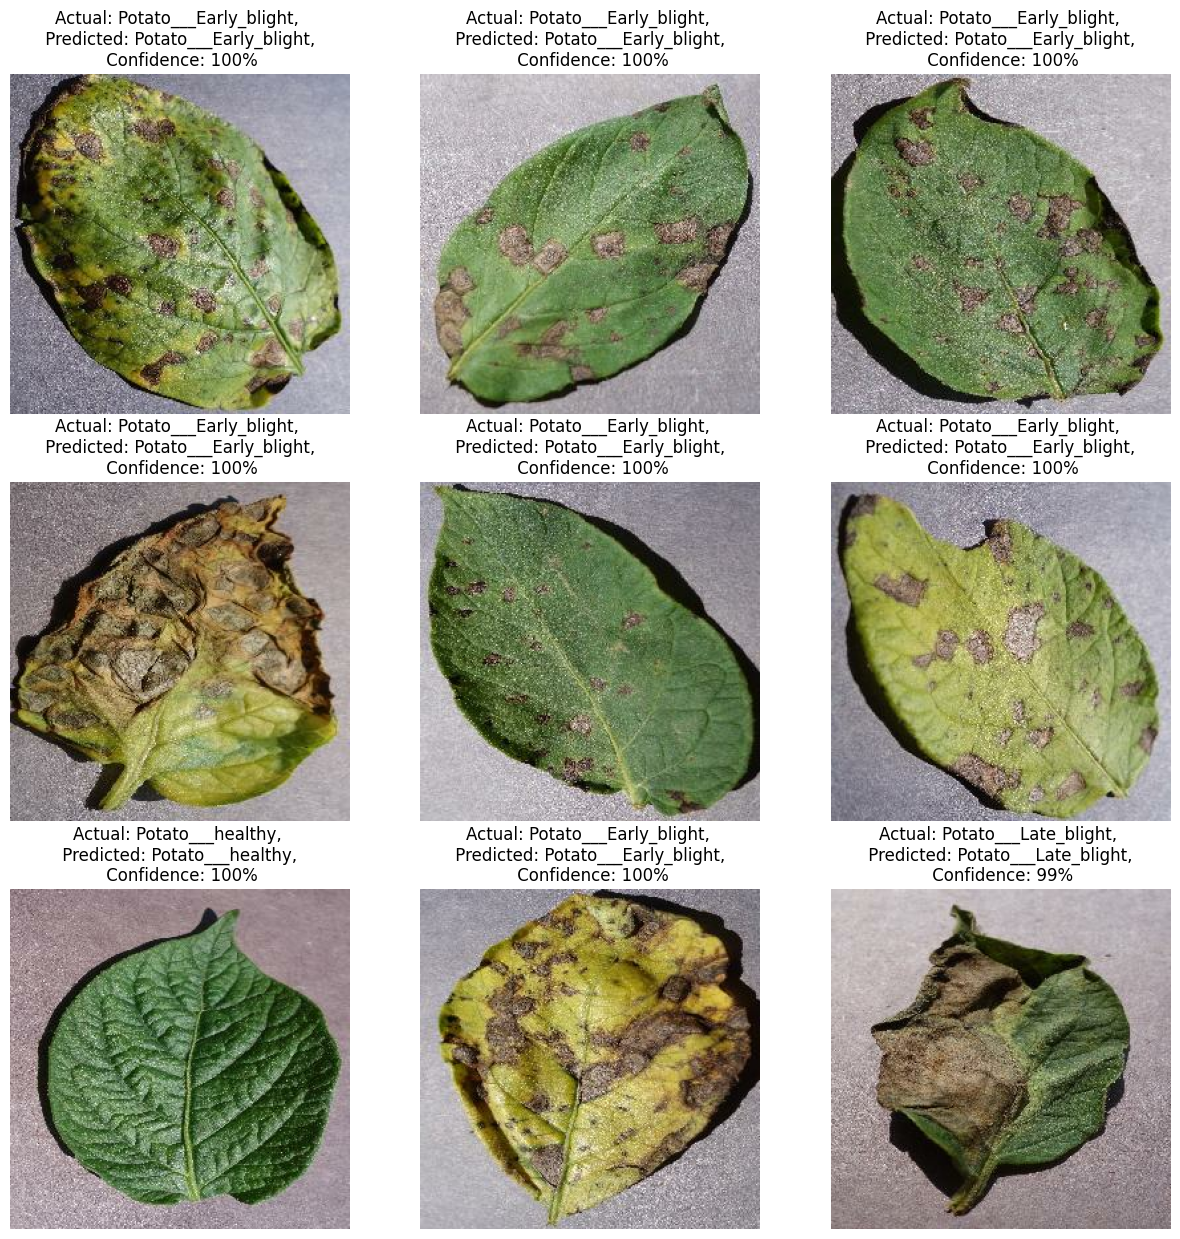

In [ ]:
import numpy as np
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")

    plt.axis("off")


In [ ]:
# Save the entire model
model.save('my_model.keras')


In [ ]:
# Save the model to Google Drive
model.save('/content/drive/My Drive/Colab Notebooks/my_leaf_model_30ep.keras')